#Model vs. Baby Project: Dimensionality Reduction,  Unsupervised Learning,  and Neural Networks

Presented by Clayton Greenwell, Chidera Ezeani, Wodsander Maxime, Nigel Mills, and Mihir Sastry for CSCI P556 Applie Machine Learning

Resources used to complete this assignment:
- Stack Overflow
- Aurélien Geron's Github code that follows the class textbook "Hands On Machine Learning"
- Code from class powerpoint slides

**Tip For Running Notebook**

If you are using Google Colab, make sure to select a GPU (even if you're not using a GPU via Edit->Notebook settings, it will give you more memory).


In [1]:
from zipfile import ZipFile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

**Project Goal and Introduction**

The goal of this project is to gain practical programming experience with dimensionality reduction, unsupervised learning, and neural networks. This project will include PCA, K-means clustering, EM (expectation-maximization), a pretrained ResNet model, and a feedforward neural network. This project will make use of scikit-learn and PyTorch.

**Model vs. Baby Benchmark Stimuli dataset:** https://osf.io/ba4g2

This dataset is a small set of test images for evaluating object recognition in zero-shot models or human subjects.

The download is a zip file that contains a few folders ("blurred", "features", etc.), each of which contains many images. In order to start working with our data, we'll need to load them all, preferably into a NumPy array.

Here, we'll set up a few folders named "blurred_folder", "features_folder", and so on, each of which contains a list of image arrays for us to work with. The first thing we'll need to do is create a variable for our zip file, and use infolist() to get a list of the individual files within it.

In [2]:
imgzip = ZipFile("image_files.zip")
inflist = imgzip.infolist()
# inflist

This includes files from every folder, so we'll have to find a way to separate them. We could just find the file numbers where each folder starts and ends, but that's not very efficient and would brick the moment we add or remove an image from any folder.

Instead, let's use the file names as strings. If we take the filename attribute for each entry in our infolist, we can check whether it contains a specific folder name, we can then add the image file as a NumPy array to a corresponding list variable. We should also check for a ".jpg" or ".JPG" extension, since there are also files in our infolist that just correspond to a folder but no file within it.

In [3]:
# Example filename for the 16th file, part of the "blurred" folder:
print(inflist[15].filename)

# Example of a filename that we have to introduce extra checks for:
print(inflist[1].filename)

# Different steps of accessing and converting the image, for reference:
# imgzip.open(inflist[15])
# Image.open(imgzip.open(inflist[15]))
# np.array(Image.open(imgzip.open(inflist[15])))

image_files/v0/blurred/Chairside_V3.jpg
image_files/v0/blurred/


In [4]:
# Create our folders:
blurred_folder = []
features_folder = []
geons_folder = []
realistic_folder = []
silhouettes_folder = []

# And label arrays, so we can easily track what each image represents:
blurred_labels = []
features_labels = []
geons_labels = []
realistic_labels = []
silhouettes_labels = []

def extract_label_from_filename(filename: str) -> int:
    labels = {"airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"}

    # Create a mapping from label names to numbers
    label_to_num = {label: idx for idx, label in enumerate(sorted(labels))}

    for label in labels:
        if label in filename.lower():
            return label_to_num[label]

    return -1


# And then append each image file & label to their respective folders:
for file in inflist:
  if ".jpg" in file.filename.lower(): # check that it's an image file
    if "/blurred/" in file.filename:
      blurred_folder.append(np.array(Image.open(imgzip.open(file))))
      blurred_labels.append(extract_label_from_filename(file.filename))
    elif "/features/" in file.filename:
      features_folder.append(np.array(Image.open(imgzip.open(file))))
      features_labels.append(extract_label_from_filename(file.filename))
    elif "/geons/" in file.filename:
      geons_folder.append(np.array(Image.open(imgzip.open(file))))
      geons_labels.append(extract_label_from_filename(file.filename))
    elif "/realistic/" in file.filename:
      realistic_folder.append(np.array(Image.open(imgzip.open(file))))
      realistic_labels.append(extract_label_from_filename(file.filename))
    elif "/silhouettes/" in file.filename:
      silhouettes_folder.append(np.array(Image.open(imgzip.open(file))))
      silhouettes_labels.append(extract_label_from_filename(file.filename))

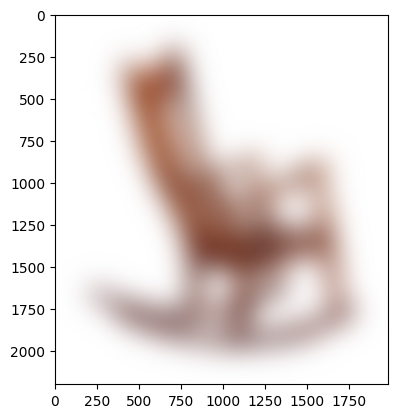

In [5]:
# And then we can use matplotlib to plot them if we want:
plt.imshow(blurred_folder[13])

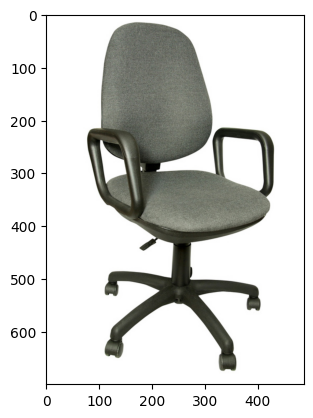

In [6]:
# Here's a different example from the "realistic" folder:
plt.imshow(realistic_folder[13])

# 1. Applying PCA to Images

Apply PCA to the images from different conditions.  How many components do you need to preserve at least 95% of the variance in each condition? Why do some conditions require more components than others?

Note that each folder contains images that match a different condition: realistic, features, blurred, geons, or silhouettes.

Also note that each of these 5 folders contains 8 types of images: airplanes, cars, chairs, cups, dogs, donkeys, ducks, and hats.

**Realistic** - a completely normal picture of an animal, object, or mode of transportation.

**Features** - fragmented pictures that only reveal certain features of the original image.

**Blurred** - blurred versions of the images.

**Geons** - basic 3D shapes of the images (rendered using cones, cylinders, cubes, etc.)

**Silhouettes** - black, silhouetted versions of the images.

In [7]:
print(
    len(blurred_folder), len(features_folder), len(geons_folder),
    len(realistic_folder), len(silhouettes_folder)
)

42 42 22 41 40


To start, we're immediately standardizing all the images to occupy the same shape & size (64 x 64), and converting them all to grayscale. This has the benefit of making it so we don't necessarily need to account for different shapes in our code later on, as well as drastically increasing the processing speed.

In [8]:
#Convert to grayscale first to standardize channels

def preprocess_images(img_list, shape=(64, 64)):
    processed = []
    for img in img_list:
        pil_img = Image.fromarray(img).convert("L")   # grayscale ("L" not "RGB")
        pil_img = pil_img.resize(shape)               # resize
        processed.append(np.array(pil_img).flatten()) # flatten
    return np.array(processed)

In [9]:
blurred_data = preprocess_images(blurred_folder)
features_data = preprocess_images(features_folder)
geons_data = preprocess_images(geons_folder)
realistic_data = preprocess_images(realistic_folder)
silhouettes_data = preprocess_images(silhouettes_folder)

print(blurred_data.shape)
print(features_data.shape)
print(geons_data.shape)
print(realistic_data.shape)
print(silhouettes_data.shape)

(42, 4096)
(42, 4096)
(22, 4096)
(41, 4096)
(40, 4096)


Now, we can get to work on finding the number of components needed to preserve 95% of our variance for each image type. We can fit each preprocessed image set on PCA, look at the explained_variance_ratio_ stat, and then use the cumsum() function to incrementally add each component's explained variance to a total. When that total passes 95%, we add one final component and return the value.

In [10]:
from sklearn.decomposition import PCA

def pca_components_for_95(data):
    pca = PCA()

    # Fit PCA on the image data (data must be num_images × num_pixels)
    pca.fit(data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)

    # Find the smallest number of components needed to reach 95% variance
    # np.argmax returns the first index where the condition is True
    comps = np.argmax(cumsum >= 0.95) + 1

    return comps

In [11]:
print("Blurred:", pca_components_for_95(blurred_data))
print("Features:", pca_components_for_95(features_data))
print("Geons:", pca_components_for_95(geons_data))
print("Realistic:", pca_components_for_95(realistic_data))
print("Silhouettes:", pca_components_for_95(silhouettes_data))

Blurred: 15
Features: 31
Geons: 16
Realistic: 30
Silhouettes: 30


To preserve at least 95% of the variance, blurred and geon images required around 15 to 16 components, while features, realistic, and silhouette images needed roughly 30 to 31 components.

The difference seems to come from the complexity of the images. Blurred and geon images are simple, containing smooth shapes and low-detail information, so most of their variation can be captured with only a few components. In contrast, features, realistic, and silhouette images contain more detail, sharper edges, and greater variation in shape, which spreads the variance across many dimensions and requires more components for PCA to capture most of the information.

This next part isn't strictly necessary, but we can get a better idea of what each principal component's contribution looks like for each image type through plotting. Below, we do it for the realistic images, but it can be done for any image set that had PCA done on it as a unit. The left plot (a "scree plot") shows each individual component's explained variance on its own, and the right plot shows the cumulative sum of all components up to that point, as well as a threshold line at 95% explained variance. We can use these plots to get a better idea of where component contribution starts to taper off.

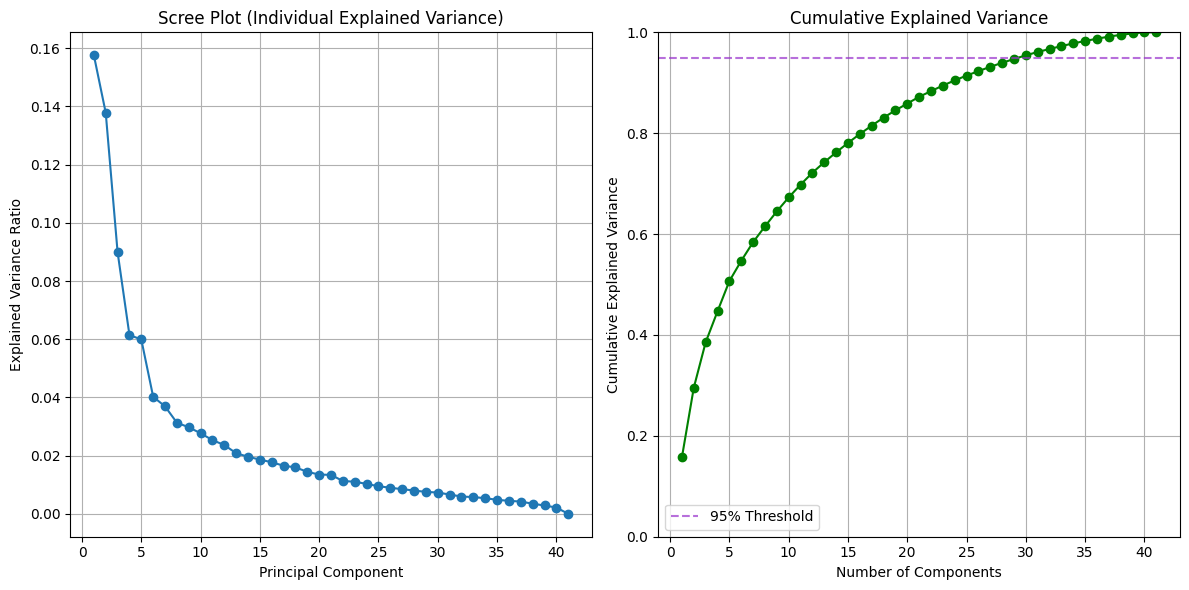

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA on realistic images
pca_realistic = PCA()
pca_realistic.fit(
    realistic_data # realistic_data is your preprocessed flattened images
)

# Explained variance ratio for each component
explained_variance_ratio = pca_realistic.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting
plt.figure(figsize=(12, 6))

# Scree plot: individual explained variance per component
plt.subplot(1, 2, 1)

plt.plot(
    np.arange(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker='o'
)

plt.title('Scree Plot (Individual Explained Variance)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

# Cumulative explained variance
plt.subplot(1, 2, 2)

plt.plot(
    np.arange(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    color='green'
)

plt.axhline(
    y=0.95,
    color='darkorchid', # red and green should never be seen!
    linestyle='--',
    alpha = 0.7,
    label='95% Threshold'
)

plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

An elbow-like bend is observed within the first ~40 components in the cumulative explained variance graph, suggesting that after this point, additional components contribute increasingly less variance. This serves as another piece of evidence that our optimal number of components is somewhere within this range.

# 2. Plot 10 Images

Plot 10 realistic images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept at least 95% of the variance using PCA.

In [13]:
# Fit PCA on realistic images
pca_realistic = PCA()
pca_realistic.fit(realistic_data)

# Find number of components to preserve at least 95% variance
cumsum = np.cumsum(pca_realistic.explained_variance_ratio_)
components_95 = np.argmax(cumsum >= 0.95) + 1
print("Components needed for 95% variance:", components_95)

Components needed for 95% variance: 30


In [14]:
# Keep only the top components
pca_realistic_95 = PCA(n_components=components_95)
realistic_projected = pca_realistic_95.fit_transform(realistic_data)
realistic_reconstructed = pca_realistic_95.inverse_transform(realistic_projected)

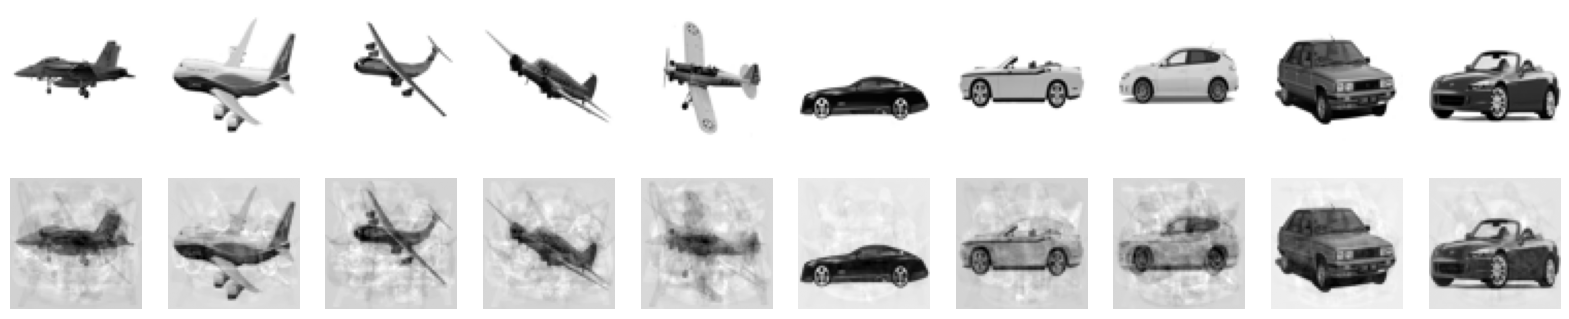

In [15]:
# Choose 10 images (first 10 for simplicity)
n_images = 10
fig, axes = plt.subplots(2, n_images, figsize=(20, 4))

for i in range(n_images):
    # Original image
    axes[0, i].imshow(realistic_data[i].reshape(64, 64), cmap='gray')
    axes[0, i].axis('off')

    # Reconstructed image
    axes[1, i].imshow(realistic_reconstructed[i].reshape(64, 64), cmap='gray')
    axes[1, i].axis('off')

axes[0,0].set_ylabel("Original", fontsize=12)
axes[1,0].set_ylabel("Reconstructed", fontsize=12)
plt.show()

For most of these (save for maybe the last plane image), the images are actually pretty well-preserved and still quite distinguishable. That's a good sign for if we were to scale up this process and try working with many more images. That said, removal of some variance via PCA did introduce clear noise to each image, which is especially noticeable in their formerly-white backgrounds.

# 3. A) Reducing Dimensionality to Only 2 Dimensions using PCA

Each of the images belongs to one of eight clusters (Airplane, Car, Chair, Cup, Dog, Donkey, Duck, Hat). The clusters are indicated by the image name. We will now try to see if the visualization can help us identify different clusters.

For each condition (folder), use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components for each condition?

>This can be done using a new PCA function with the n_components parameter set to 2. In the explain_variance() function below, we do exactly that, then project it onto the data, and then use the explained_variance_ratio_ feature like before to find the two first PCs' explained variance. For convenience, this is output as a table containing information on each image condition's first component EV, second component EV, and combined EV.

>Before that, though, we also scale our data via standardization. This seems to be highly recommended for PCA in general, specifically because it can help deal with disparate variable ranges as usual. Considering our dataset ranges from 0-255 in brightness anyway for all dimensions (pixels), scaling might not be quite as impactful for this specific use case, but it certainly can't hurt.

In [16]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

scaler = StandardScaler()

# scale all the folders
blurred_scaled = scaler.fit_transform(blurred_data)
features_scaled = scaler.fit_transform(features_data)
geons_scaled = scaler.fit_transform(geons_data)
realistic_scaled = scaler.fit_transform(realistic_data)
silhouettes_scaled = scaler.fit_transform(silhouettes_data)

def explain_variance(data, n_components = 2):

  # Define the dimensions
  _2_dim_pca = PCA(n_components)

  # Perform PCA
  data_projected = _2_dim_pca.fit(data)

  # Explained variances
  explained_variance = _2_dim_pca.explained_variance_ratio_

  return explained_variance

# Calculate explained variance for each condition
conditions = ['Blurred', 'Features', 'Geons', 'Realistic', 'Silhouettes']
headers = ["Conditions", "PC 1", "PC 2", "Combined PCs"]
datasets = [blurred_scaled,
            features_scaled,
            geons_scaled,
            realistic_scaled,
            silhouettes_scaled
]

variance_data = []
for condition, data in zip(conditions, datasets):
    variance = explain_variance(data)
    variance_data.append([condition, variance[0], variance[1], sum(variance)])

print(tabulate(variance_data, headers = headers,  tablefmt="grid"))

+--------------+-----------+-----------+----------------+
| Conditions   |      PC 1 |      PC 2 |   Combined PCs |
+==============+===========+===========+================+
| Blurred      | 0.208656  | 0.118151  |       0.326806 |
+--------------+-----------+-----------+----------------+
| Features     | 0.0867058 | 0.0746486 |       0.161354 |
+--------------+-----------+-----------+----------------+
| Geons        | 0.257682  | 0.170681  |       0.428363 |
+--------------+-----------+-----------+----------------+
| Realistic    | 0.112842  | 0.102022  |       0.214864 |
+--------------+-----------+-----------+----------------+
| Silhouettes  | 0.173897  | 0.113855  |       0.287752 |
+--------------+-----------+-----------+----------------+


There's some variability in how much variance is explained by the first two PCs for each condition. Geons get the most at nearly 43%, followed by Blurred at around 33%. Features has by far the lowest at just over 16%. In general, it seems like we can explain more variance with fewer principal components for images that are less detailed and have fewer distinct visual parts to keep track of.

#3. B) Scatter Plots

Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image class (so you will have eight different colors). Repeat the process and create the same type of plots for t-SNE, LLE and UMAP.

In [17]:
import warnings
warnings.filterwarnings("ignore")

Blurred: 42 samples, 8 unique labels
Features: 42 samples, 9 unique labels
Geons: 22 samples, 7 unique labels
Realistic: 41 samples, 8 unique labels
Silhouettes: 40 samples, 8 unique labels

Blurred: 42 samples
Running PCA for Blurred...
Running t-SNE for Blurred (perplexity=30)...
Running LLE for Blurred (n_neighbors=10)...
Running UMAP for Blurred...


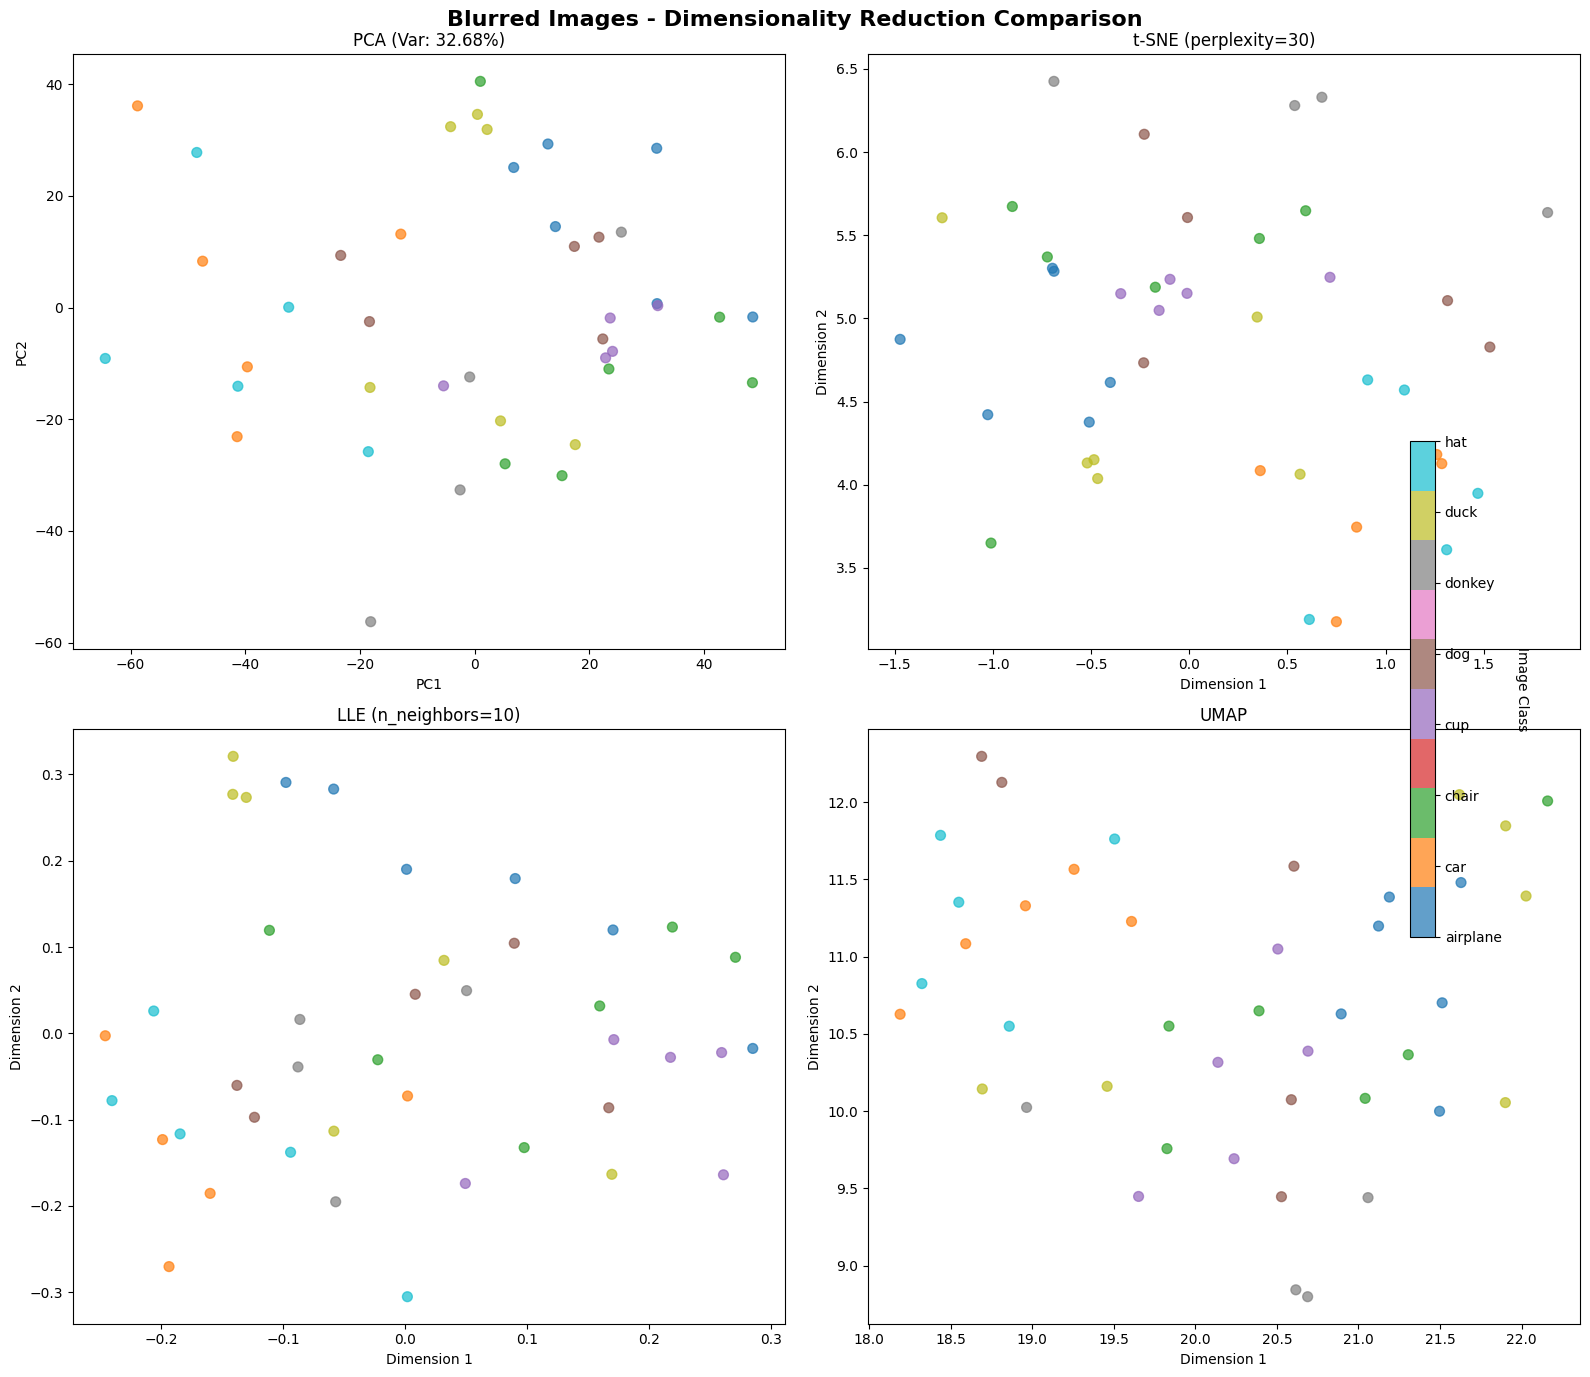


Features: 42 samples
Running PCA for Features...
Running t-SNE for Features (perplexity=30)...
Running LLE for Features (n_neighbors=10)...
Running UMAP for Features...


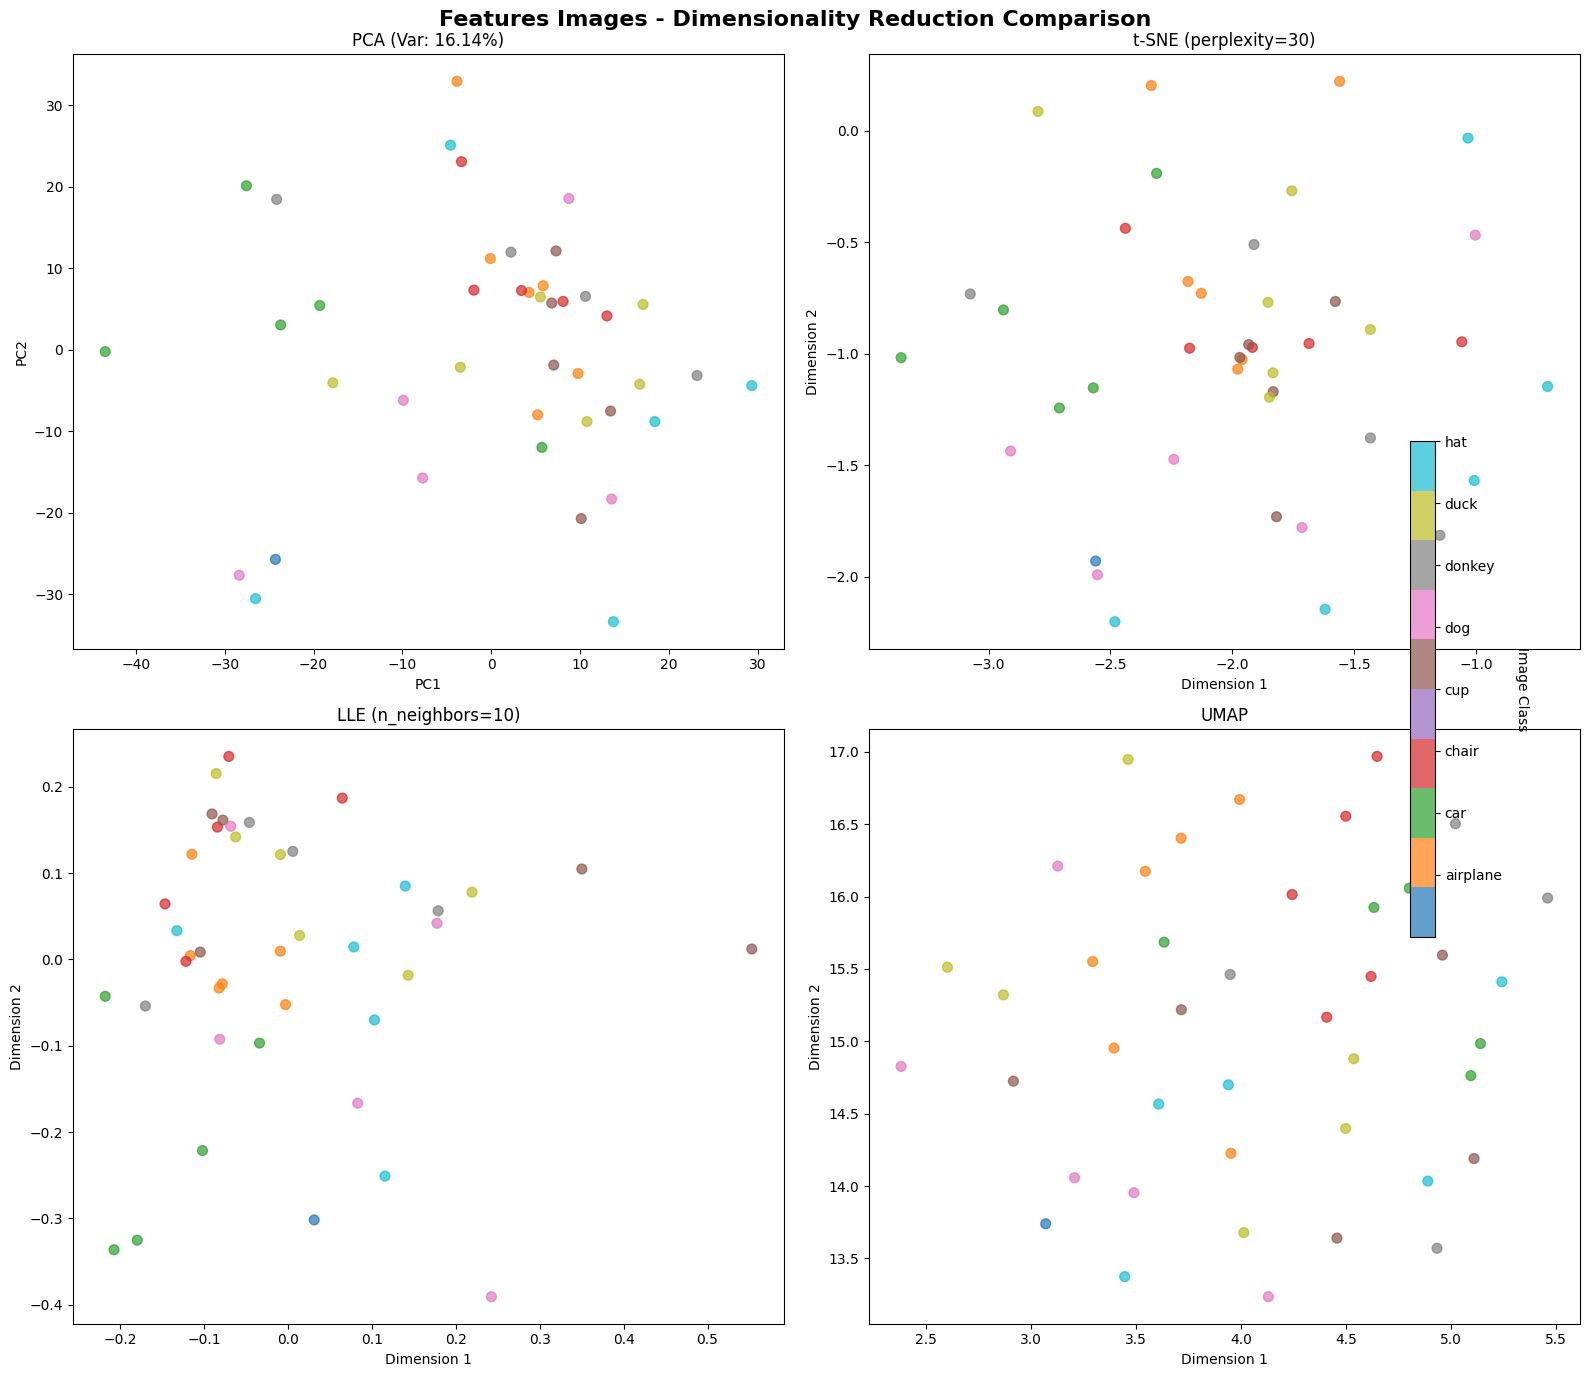


Geons: 22 samples
Running PCA for Geons...
Running t-SNE for Geons (perplexity=21)...
Running LLE for Geons (n_neighbors=10)...
Running UMAP for Geons...


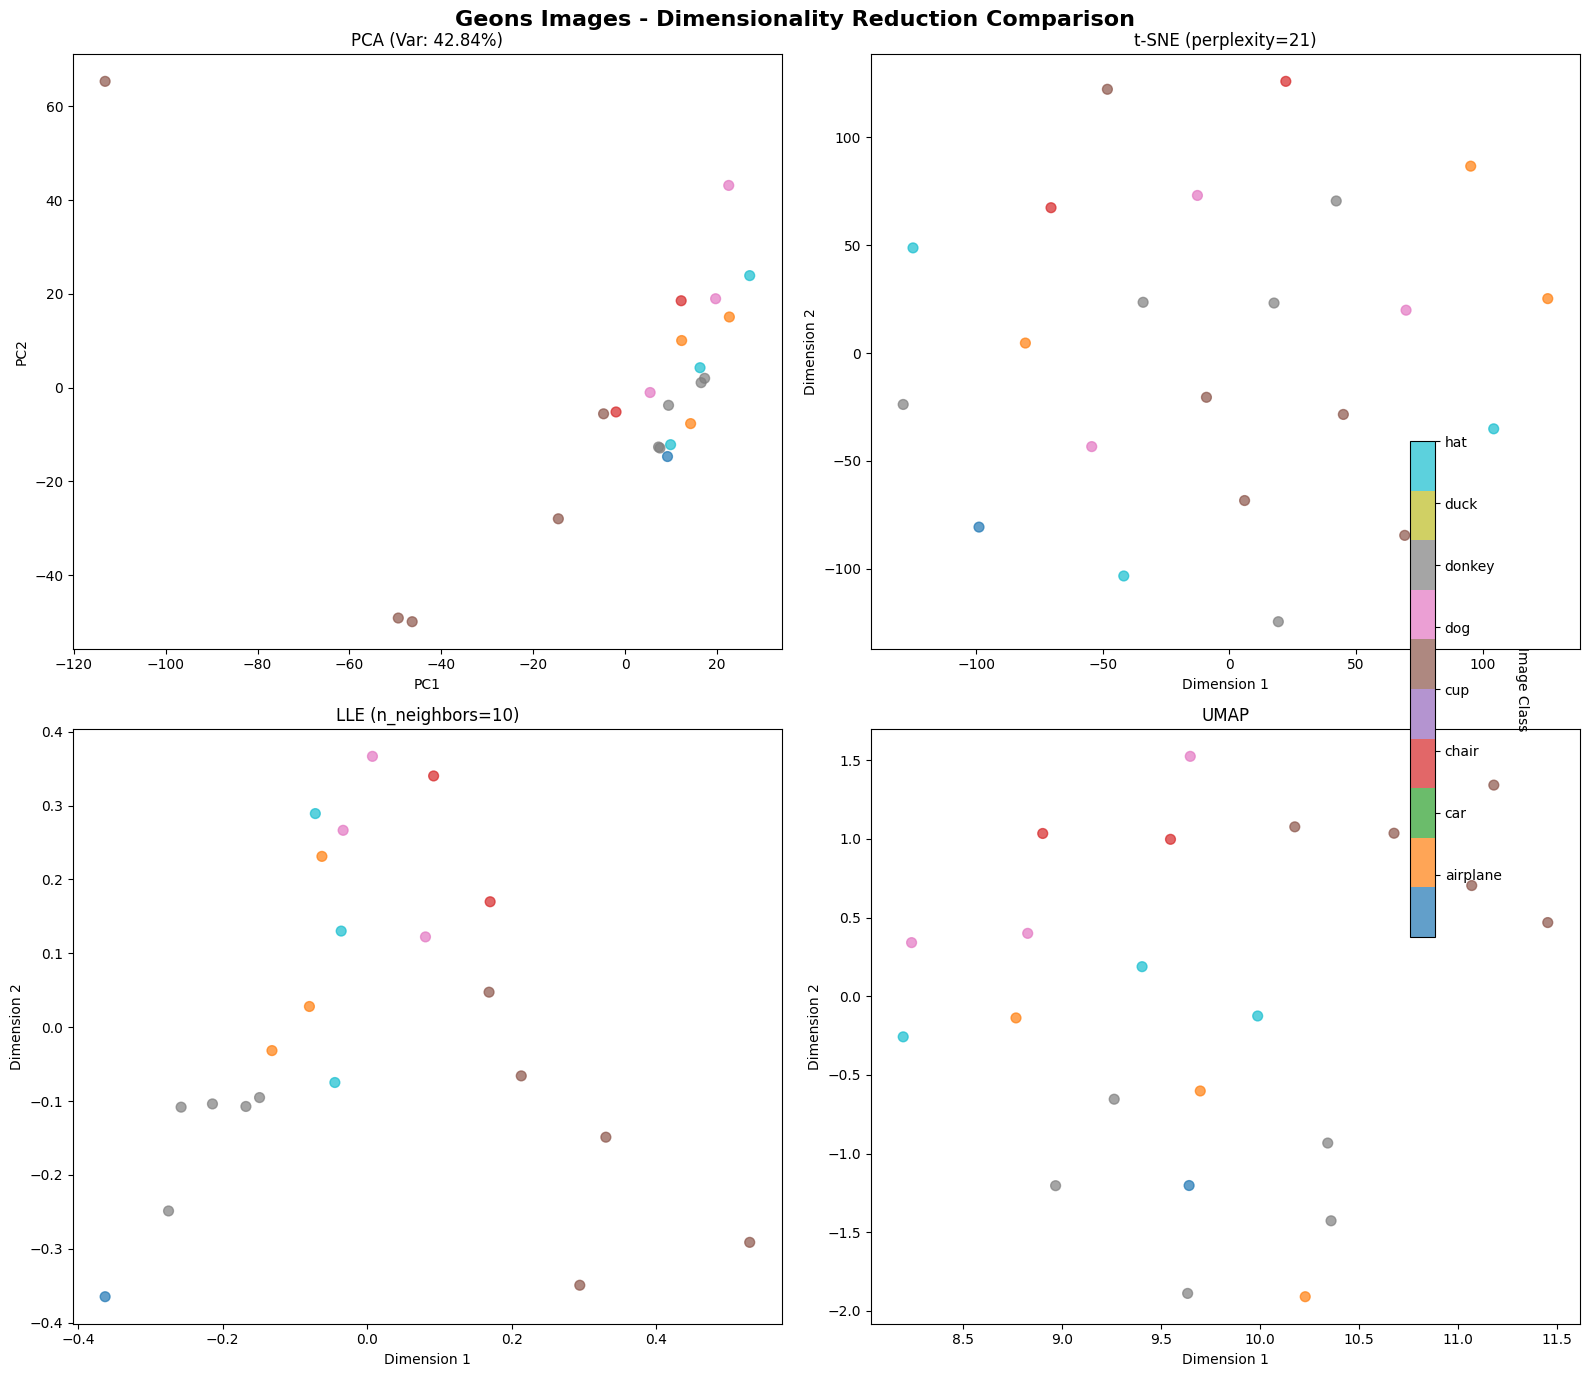


Realistic: 41 samples
Running PCA for Realistic...
Running t-SNE for Realistic (perplexity=30)...
Running LLE for Realistic (n_neighbors=10)...
Running UMAP for Realistic...


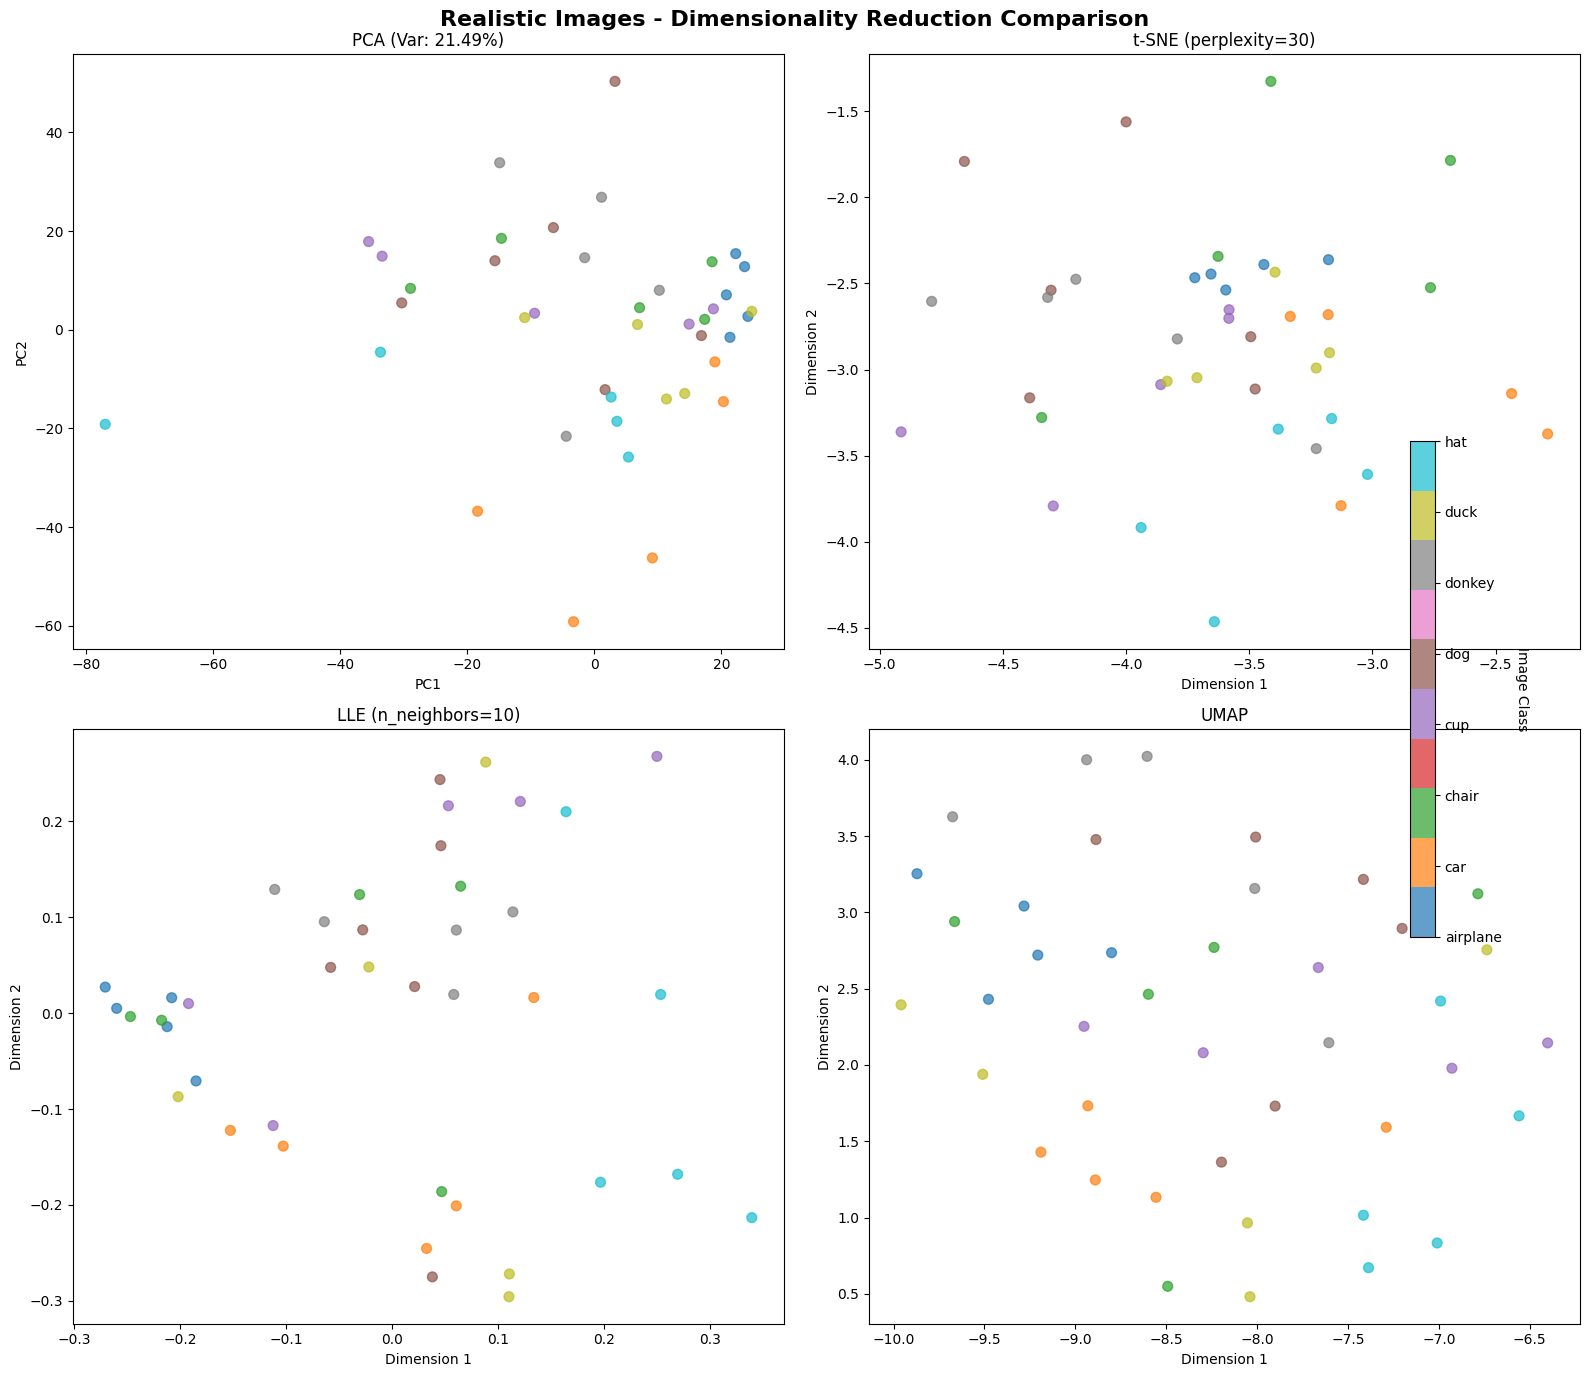


Silhouettes: 40 samples
Running PCA for Silhouettes...
Running t-SNE for Silhouettes (perplexity=30)...
Running LLE for Silhouettes (n_neighbors=10)...
Running UMAP for Silhouettes...


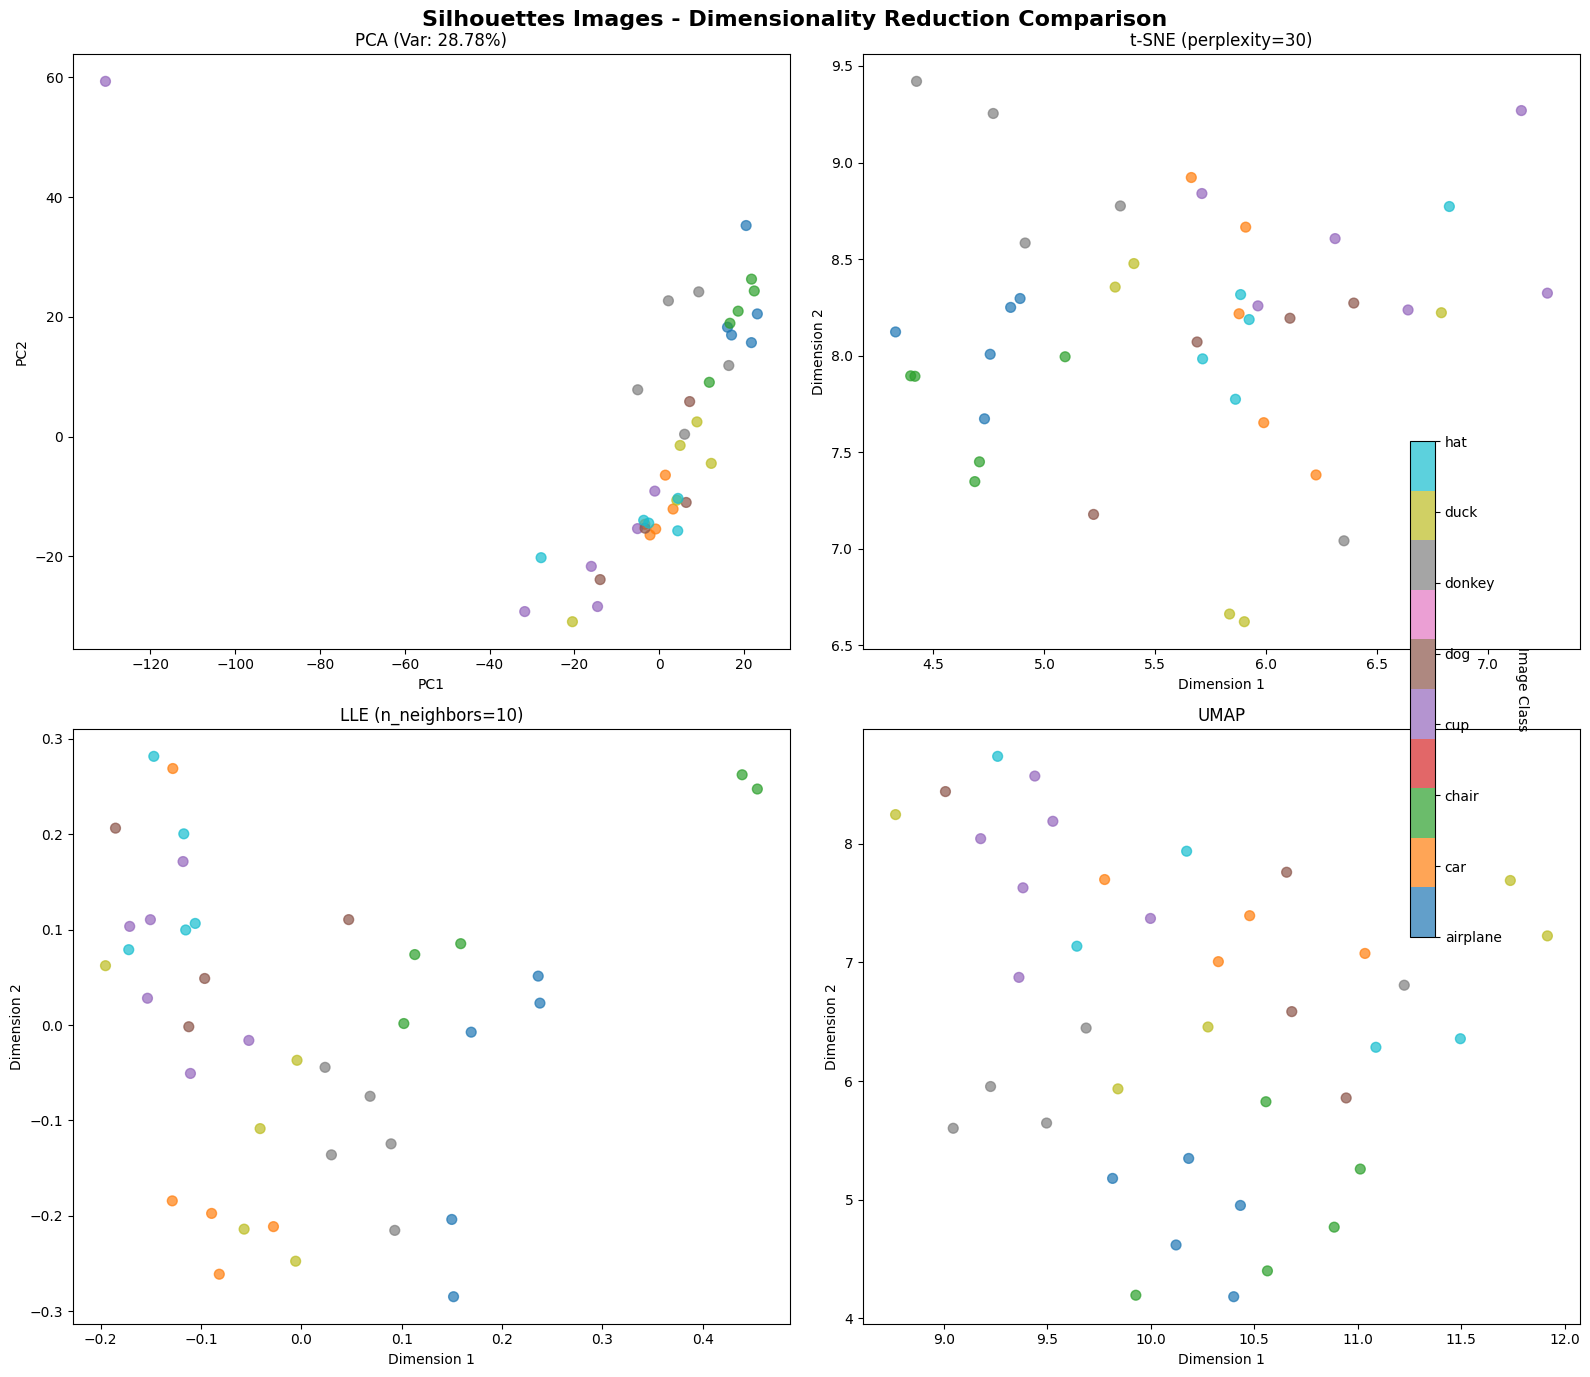

In [18]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from umap import UMAP

def plot_dimensionality_reduction(data, labels, condition_name):

    # Define the 8 class names
    class_names = ['airplane','car','chair','cup','dog','donkey','duck','hat']

    n_samples = data.shape[0]
    print(f"\n{condition_name}: {n_samples} samples")

    # Adjust parameters based on sample size
    perplexity = min(30, n_samples - 1)  # t-SNE perplexity must be < n_samples
    n_neighbors = min(10, n_samples - 1)  # LLE n_neighbors must be < n_samples

    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle(f'{condition_name} Images - Dimensionality Reduction Comparison',
                 fontsize=16, fontweight='bold')

    # 1. PCA
    print(f"Running PCA for {condition_name}...")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    scatter1 = axes[0, 0].scatter(pca_result[:, 0], pca_result[:, 1],
                                  c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 0].set_title(f'PCA (Var: {pca.explained_variance_ratio_.sum():.2%})')
    axes[0, 0].set_xlabel('PC1')
    axes[0, 0].set_ylabel('PC2')

    # 2. t-SNE
    print(f"Running t-SNE for {condition_name} (perplexity={perplexity})...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_result = tsne.fit_transform(data)

    scatter2 = axes[0, 1].scatter(tsne_result[:, 0], tsne_result[:, 1],
                                  c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 1].set_title(f't-SNE (perplexity={perplexity})')
    axes[0, 1].set_xlabel('Dimension 1')
    axes[0, 1].set_ylabel('Dimension 2')

    # 3. LLE
    print(f"Running LLE for {condition_name} (n_neighbors={n_neighbors})...")
    lle = LocallyLinearEmbedding(
        n_components=2,
        random_state=42,
        n_neighbors=n_neighbors
    )
    lle_result = lle.fit_transform(data)

    scatter3 = axes[1, 0].scatter(lle_result[:, 0], lle_result[:, 1],
                                  c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[1, 0].set_title(f'LLE (n_neighbors={n_neighbors})')
    axes[1, 0].set_xlabel('Dimension 1')
    axes[1, 0].set_ylabel('Dimension 2')

    # 4. UMAP
    print(f"Running UMAP for {condition_name}...")
    umap_model = UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=min(15, n_samples - 1)
    )
    umap_result = umap_model.fit_transform(data)

    scatter4 = axes[1, 1].scatter(umap_result[:, 0], umap_result[:, 1],
                                  c=labels, cmap='tab10', alpha=0.7, s=50)
    axes[1, 1].set_title('UMAP')
    axes[1, 1].set_xlabel('Dimension 1')
    axes[1, 1].set_ylabel('Dimension 2')

    # Add a shared colorbar
    cbar = plt.colorbar(scatter4, ax=axes, orientation='vertical',
                       fraction=0.02, pad=0.04)
    cbar.set_label('Image Class', rotation=270, labelpad=20)
    cbar.set_ticks(range(8))
    cbar.set_ticklabels(class_names)

    plt.tight_layout()
    plt.show()

# Example usage for each condition:
conditions = ['Blurred', 'Features', 'Geons', 'Realistic', 'Silhouettes']
datasets = [blurred_scaled,
            features_scaled,
            geons_scaled,
            realistic_scaled,
            silhouettes_scaled
]
labels_list = [blurred_labels,
               features_labels,
               geons_labels,
               realistic_labels,
               silhouettes_labels
]

# Check sample sizes before plotting
for condition, data, labels in zip(conditions, datasets, labels_list):
    print(
        f"{condition}: "
        f"{data.shape[0]} samples, "
        f"{len(np.unique(labels))} unique labels"
    )

# Now plot
for condition, data, labels in zip(conditions, datasets, labels_list):
    plot_dimensionality_reduction(data, labels, condition)

No obscenely noticeable patterns for objects of similar classes having similar values on our plots; however, we might start to see patterns emerge if we had more images. Ideally, we'd be able to see some sort of pattern in the dimension values for each cluster, which would help a model guess what category a new image is in based on those same dimension values.

Some of the PCA plots also tend to have their points cluster in the bottom-right quarter, but that's fine.

# 4. A) K-means Clustering

Cluster the images in each condition using K-Means (apply K-means separately to images from each folder).


To make the process faster, reduce the dimensionality using PCA, but keep at least 95% of the variance. Determine the number of clusters using one of the techniques we discussed in class, suitable for the K-means algorithm.

>Silhouette score is our chosen way of calculating the "optimal" number of clusters. Implementing it is relatively simple thanks to sklearn's silhouette_score() function. Individual silhouette coefficients are calculated for each image after clustering, with instances that are more nested within their own clusters receiving higher coefficients. The silhouette score is just the mean of all silhouette coefficients, so a higher score is also better. Because of that, once we've calculated all the different silhouette scores for different numbers of clusters (within a reasonable range -- we test from 2 to 11 clusters), we can just use argmax() to find the best value of k for each folder.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict

results = {}

pcaED_data = defaultdict(list)   # datasets but now they all have the pca

for condition, data, labels in zip(conditions, datasets, labels_list):

    print(f"{condition}")

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.95, svd_solver='full')
    data_pca = pca.fit_transform(data)
    pcaED_data[condition].append(data_pca)

    print(f"Original dim: {data.shape[1]}, PCA dim: {data_pca.shape[1]}")

    # Determine number of clusters (silhouette)
    k_values = range(2, 11)
    sil_scores = []

    for k in k_values:
        kmeans_temp = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans_temp.fit_predict(data_pca)
        score = silhouette_score(data_pca, cluster_labels)
        sil_scores.append(score)

    best_k = k_values[np.argmax(sil_scores)]
    print(f"Best k (silhouette): {best_k}")

    # Fit final K-means with best k
    kmeans_final = KMeans(n_clusters=best_k, random_state=42)
    final_labels = kmeans_final.fit_predict(data_pca)

    # Store results for later usage
    results[condition] = {
        "pca_components": data_pca,
        "n_components": data_pca.shape[1],
        "best_k": best_k,
        "cluster_labels": final_labels,
        "silhouette_scores": sil_scores
    }
    print()


print("\nFinished clustering all conditions")

Blurred
Original dim: 4096, PCA dim: 22
Best k (silhouette): 3

Features
Original dim: 4096, PCA dim: 32
Best k (silhouette): 2

Geons
Original dim: 4096, PCA dim: 16
Best k (silhouette): 2

Realistic
Original dim: 4096, PCA dim: 29
Best k (silhouette): 2

Silhouettes
Original dim: 4096, PCA dim: 30
Best k (silhouette): 5


Finished clustering all conditions


The cluster counts (Best K) appear to be very low. Remember that we should actually have 8 clusters, but we're seeing numbers here as low as 2.

#4. B) Manually Setting 8 Clusters

Set the number of clusters to 8 (ground truth), report clustering accuracy (choose an appropriate mapping) and show a confusion matrix.

>Our cluster counts in part 4A ended up being quite low! Thankfully, we can intervene and set k to a static value that we know to be factually true. There are 8 image categories, so we want k = 8 clusters.

>As for our clustering accuracy, using the actual accuracy score isn't generally advised for k-means clustering. Because it's an unsupervised process that doesn't use labeling, it doesn't really make sense to compare it to labels that we assign to our items without actually feeding them into our model. Oftentimes, a different metric is better, such as the silhouette score used in part 4A. Below, silhouette score is calculated for each condition with k = 8 clusters.

>However, for the purposes of this problem (and generally in situations where we know how each item *should* be clustered), we can still assign labels. We already assigned each image a "truth" label from 0 to 7 based on what it portrays, so we can compare these to the "predictive" labels generated by the K-means clustering. It's very unlikely that the truth label and predictive label numbers correspond to the same categories, so our mapping should try to align them. The label numbers don't change with this code, but they are matched as desired.

>From there, we can compute our confusion matrix. Note that because of the way we did our label matching, the heatmap is going to look weird and not run a diagonal, but it's actually fine! Just a product of the method.

In [20]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns

print("Silhouette scores for k = 8 clusters:")

for condition, data, labels in zip(conditions, datasets, labels_list):
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.95, svd_solver='full')
    data_pca = pca.fit_transform(data)
    pcaED_data[condition].append(data_pca)

    # Fit K-Means with k = 8
    kmeans = KMeans(n_clusters = 8, random_state = 42)
    cluster_labels = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, cluster_labels)
    print(f"{condition}: {score:.4f}")

Silhouette scores for k = 8 clusters:
Blurred: 0.0505
Features: 0.0186
Geons: 0.0645
Realistic: 0.1294
Silhouettes: 0.0718


Accuracy for Blurred: 0.4286


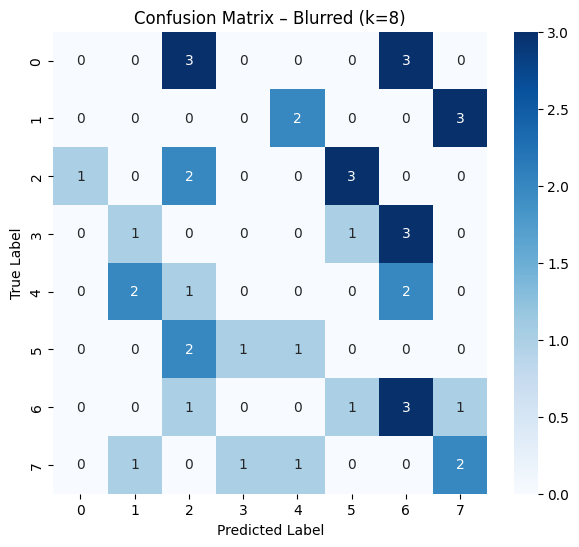

Accuracy for Features: 0.3810


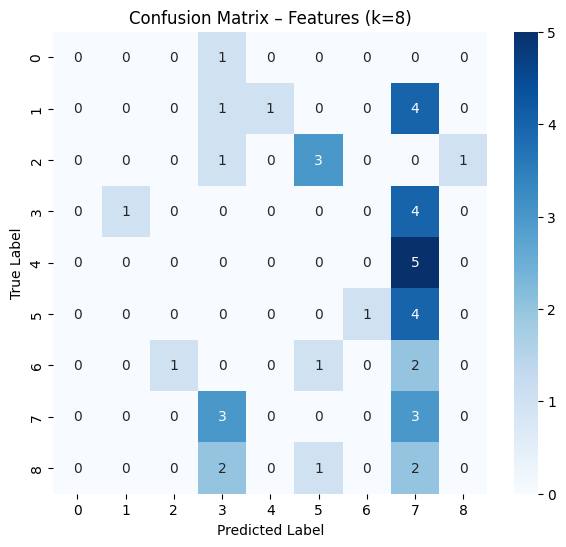

Accuracy for Geons: 0.6364


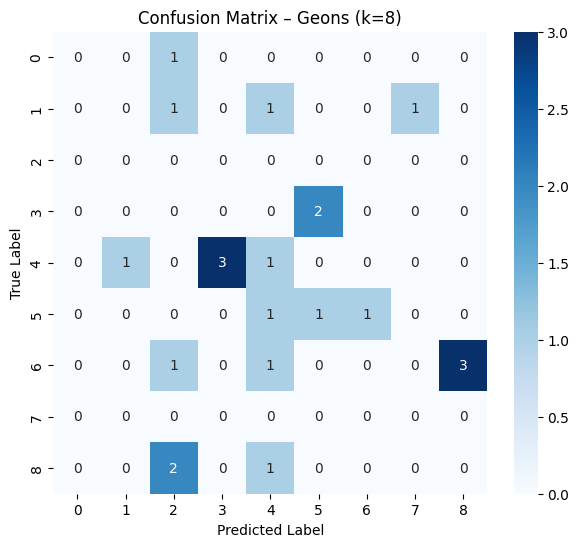

Accuracy for Realistic: 0.3415


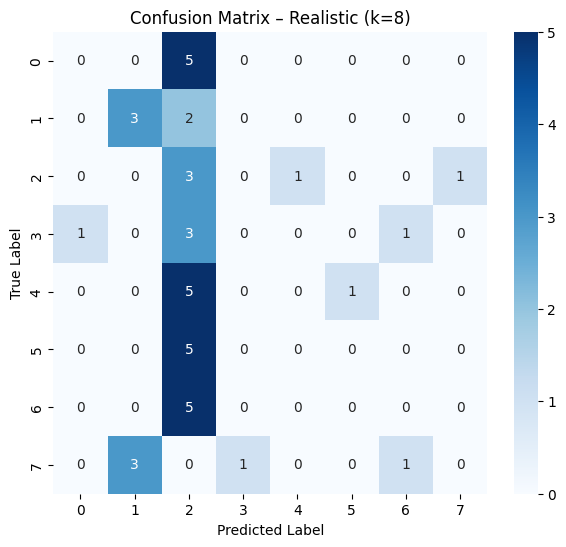

Accuracy for Silhouettes: 0.4750


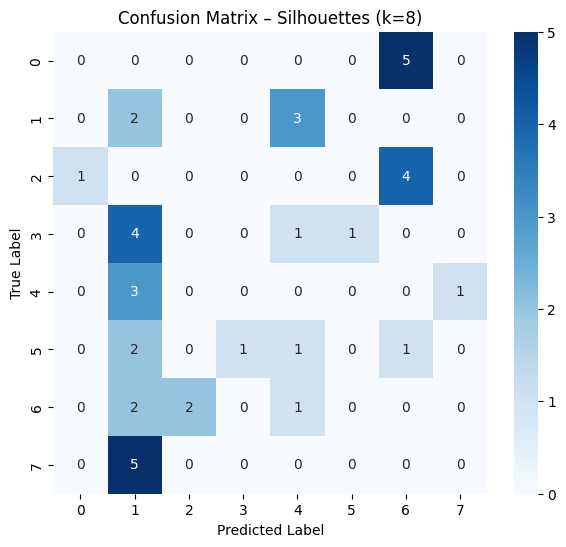

In [21]:
for condition, data, labels in zip(conditions, datasets, labels_list):

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.95, svd_solver='full')
    data_pca = pca.fit_transform(data)
    pcaED_data[condition].append(data_pca)

    # Fit K-Means with k = 8
    kmeans = KMeans(n_clusters = 8, random_state = 42)
    cluster_labels = kmeans.fit_predict(data_pca)

    # Mapping to try and match truth and predictive labels
    k_labels = kmeans.labels_
    k_labels_matched = np.empty_like(k_labels)
    for k in np.unique(k_labels):
      match_nums = [
          np.sum(
              (k_labels == k) * (labels == t)
          )
          for t in np.unique(labels)
      ]
      k_labels_matched[k_labels == k] = np.unique(labels)[np.argmax(match_nums)]

    # Compute accuracy score between truth and predictive labels
    accuracy = np.mean(labels == k_labels_matched)
    print(f"Accuracy for {condition}: {accuracy:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(labels, k_labels)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {condition} (k=8)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Accuracy is pretty paltry overall, but considering how few images we're training our models on, they're honestly not *too* bad. Funny enough, our "realistic" condition, which should theoretically be the easiest to identify since it provides the most detail, actually had the lowest accuracy (a little over 34%). This is probably due to a lot of that identifiable detail being taken away from both the PCA and the image preprocessing, which ironically could make the realistic images *more* difficult to ID than the images with just a few simple shapes or outlines. And true to form, it's actually geons which is the condition with by far the highest accuracy here (over 63%!).

#5. A) EM (Expectation-Maximization)

Cluster each condition using EM.


Reduce again the dimensionality using PCA, but keep at least 95% of the variance. Determine the number of clusters using one of the techniques we discussed in class, suitable for the EM algorithm.

>In this step, we reduced the dimensionality of the data with PCA while keeping 95% of the variance. Then we fit a Gaussian Mixture Model to cluster the images into 8 groups. This creates a low-dimensional representation that the EM algorithm can model more effectively.

In [22]:
from sklearn.mixture import GaussianMixture

conditions = ['Blurred','Features','Geons','Realistic','Silhouettes']
datasets = [
    blurred_data,
    features_data,
    geons_data,
    realistic_data,
    silhouettes_data
]
gmm_results = {}

for name, data in zip(conditions, datasets):

    # PCA (95%), then fit GMM with 8 components (n_components)
    scaler = StandardScaler().fit(data)
    data_s = scaler.transform(data)
    pca = PCA(n_components=0.95, svd_solver='full').fit(data_s)
    data_p = pca.transform(data_s)
    gmm = GaussianMixture(
        n_components=8,
        covariance_type='full',
        random_state=42
    ).fit(data_p)

    gmm_results[name] = {
    'scaler': scaler,
    'pca': pca,
    'gmm': gmm,
    'data_p': data_p
    }

    print(
    name,
    "-> PCA dims:", data_p.shape[1],
    " GMM converged:", gmm.converged_
    )

Blurred -> PCA dims: 22  GMM converged: True
Features -> PCA dims: 32  GMM converged: True
Geons -> PCA dims: 16  GMM converged: True
Realistic -> PCA dims: 29  GMM converged: True
Silhouettes -> PCA dims: 30  GMM converged: True


The PCA results show how many dimensions were needed to capture 95% of the variance, and the Gaussian Mixture Model output indicates how the data was grouped into 8 clusters. These cluster sizes help us see whether certain object categories are easier or harder for the model to separate in each visual condition.

#5. B) Manually Setting 8 Clusters (EM)
Set the number of clusters to 8 (ground truth), report clustering accuracy (choose an appropriate mapping) and show a confusion matrix.

> Using the GMM cluster assignments, we mapped each cluster to the true category it contained most often (simple majority-vote rule). This allowed us to compute accuracy and plot confusion matrices that show how well the unsupervised EM clustering recovered the 8 categories. Clearer diagonal patterns indicate that the GMM captured meaningful structure in that visual condition.

In [23]:
# majority vote
from sklearn.metrics import accuracy_score
from collections import Counter

labels_list = [
    blurred_labels,
    features_labels,
    geons_labels,
    realistic_labels,
    silhouettes_labels
]

def map_clusters_majority(y_true, y_pred, n_classes=8):

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    mapping = {}

    # For each cluster (column), find the true label with highest count (mode)
    for cluster_id in range(cm.shape[1]):

        # find row index (true label) with max count for this cluster
        col_counts = cm[:, cluster_id]
        if col_counts.sum() == 0:
            mapping[cluster_id] = cluster_id
        else:
            mapped_label = int(np.argmax(col_counts))
            mapping[cluster_id] = mapped_label

    # apply mapping
    y_pred_mapped = np.array([mapping.get(c, c) for c in y_pred], dtype=int)
    return y_pred_mapped, cm

Blurred accuracy (majority-mapped) = 0.429


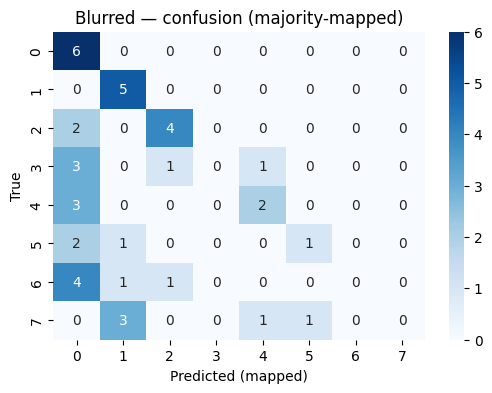

Features accuracy (majority-mapped) = 0.381


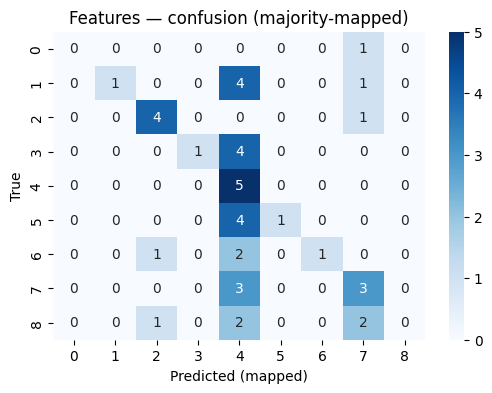

Geons accuracy (majority-mapped) = 0.636


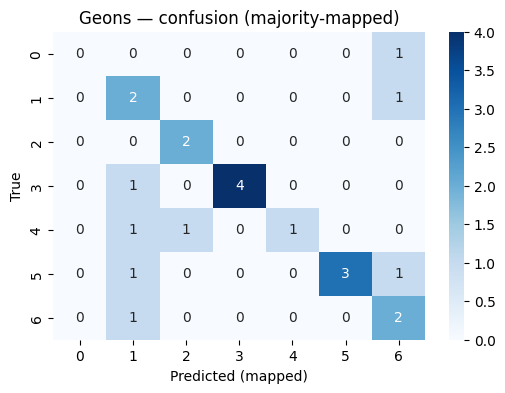

Realistic accuracy (majority-mapped) = 0.341


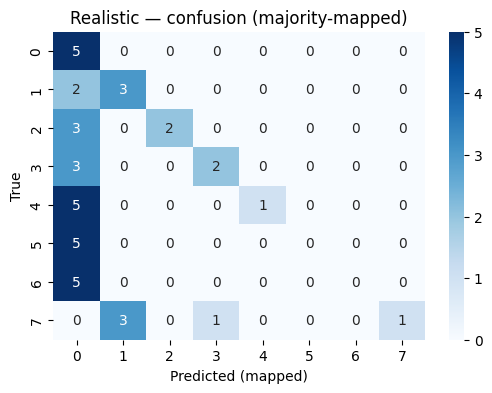

Silhouettes accuracy (majority-mapped) = 0.475


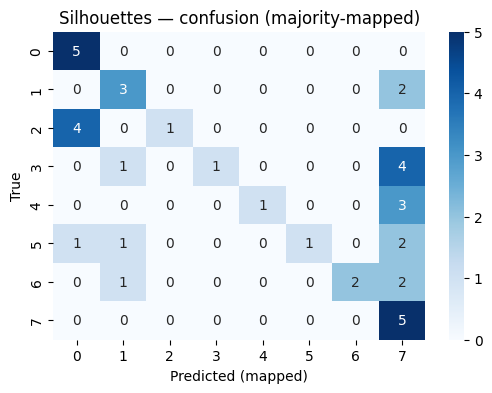

In [24]:
for name, data, y_true in zip(conditions, datasets, labels_list):
    info = gmm_results[name]

    # predict using the GMM in PCA
    y_pred = info['gmm'].predict(
        info['pca'].transform(
            info['scaler'].transform(data)
        )
    )

    # Map cluster IDs: true labels by majority vote
    y_pred_mapped, raw_cm = map_clusters_majority(y_true, y_pred, n_classes=8)

    # compute accuracy
    acc = accuracy_score(y_true, y_pred_mapped)
    print(f"{name} accuracy (majority-mapped) = {acc:.3f}")

    # plot confusion matrix: true vs. mapped-predicted
    plt.figure(figsize=(6,4))
    sns.heatmap(
        confusion_matrix(y_true, y_pred_mapped),
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    plt.title(f"{name} — confusion (majority-mapped)")
    plt.xlabel("Predicted (mapped)"); plt.ylabel("True")
    plt.show()

After mapping clusters to true labels, the confusion matrices show how well the GMM clusters align with the 8 true categories: a strong diagonal and high accuracy indicate the EM algorithm recovered the underlying object classes, while large off-diagonal blocks reveal confusion between categories. "Geons" appears to have the strongest alignment with the true categories. "Realistic" appears to be the worst performing (there is substantial model confusion according to this matrix).

#5. C) 5 New Images

Use the model to generate 5 new images for each condition (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).

> Using the trained GMMs, we sample new synthetic points in PCA space and invert the PCA and scaling steps to reconstruct them as images. These generated images will show what the model thinks each visual condition looks like.

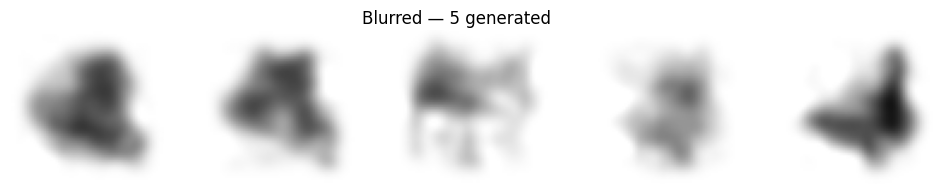

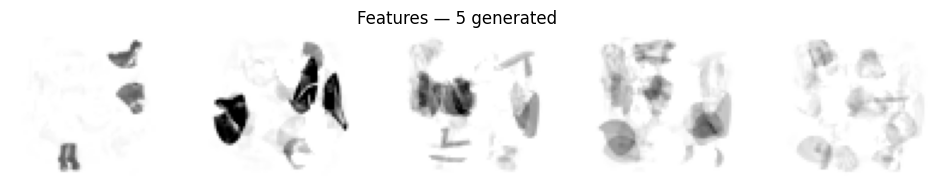

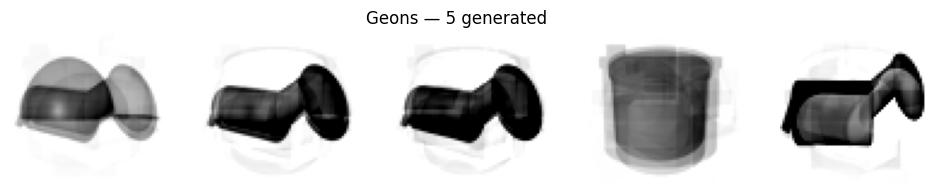

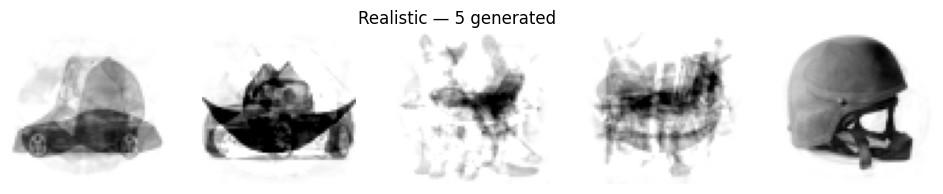

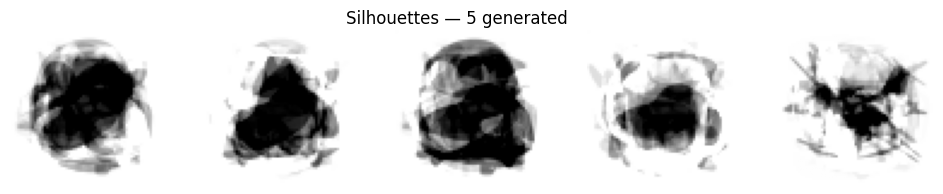

In [25]:
n_generate = 5
img_h, img_w = 64, 64  # dimensions

for name in conditions:
    info = gmm_results[name]
    samples_pca, _ = info['gmm'].sample(n_generate)
    samples_scaled = info['pca'].inverse_transform(samples_pca)
    samples_raw = info['scaler'].inverse_transform(samples_scaled)
    plt.figure(figsize=(12,2))

    for i, s in enumerate(samples_raw):
        img = np.clip(s.reshape(img_h, img_w), 0, 255)
        plt.subplot(1, n_generate, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')

    plt.suptitle(f"{name} — {n_generate} generated")
    plt.show()

The generated images visualize what the model learned about each condition. Clear, recognizable samples suggest the model captured the main patterns of that condition, while blurry/noisy samples indicate the model struggled to learn a functional representation.

Comparing visual conditions, the model clearly struggled with "silhouettes" (these are unrecongizable). "Realistic", "geons", and "blurred" have some real recognizable results. The right most column looks remarkable in all 3 sets. Because of the grey scale, it's very difficult to tell how the model performed on "features".

#5. D) ResNet Model

Repeat part 5B, but instead of features derived using PCA, use features obtained with a pretrained ResNet model.

> Instead of PCA, we'll extracted features from each image using a pretrained ResNet model and then cluster those features with a GMM the same way as before. This tests whether deeper, learned features improve clustering accuracy compared to PCA features.

In [26]:
import torch
import torch.nn as nn
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load pretrained resnet18
try:
    resnet = models.resnet18(pretrained=True)
except Exception:
    resnet = models.resnet18(pretrained=False)
backbone = nn.Sequential(*list(resnet.children())[:-1]).to(device)
backbone.eval()

def extract_features_from_flatbatch(flat_arrs, batch_size=64):

    # flat_arrs: (n, 4096) flattened 64x64 images
    tensors = []

    for arr in flat_arrs:
        img = arr.reshape(64,64).astype('uint8')
        img_rgb = np.stack([img]*3, axis=2)               # duplicate channels
        t = transforms.ToTensor()(img_rgb).unsqueeze(0)  # [1,3,H,W]
        t = transforms.functional.resize(t, (224,224))   # to ResNet input
        tensors.append(t.squeeze(0))
    X = torch.stack(tensors).to(device)
    with torch.no_grad():
        feats = backbone(X).view(X.size(0), -1).cpu().numpy()
    return feats

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Blurred ResNet-GMM accuracy (majority-mapped) = 0.500


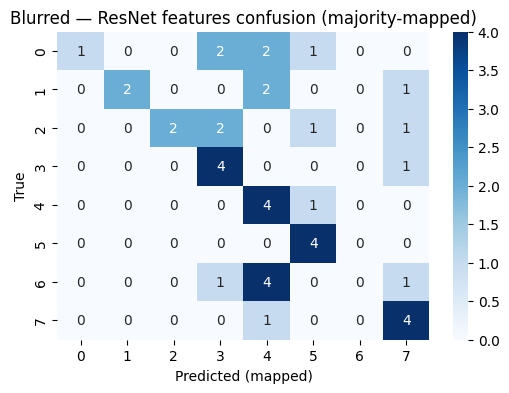

Features ResNet-GMM accuracy (majority-mapped) = 0.333


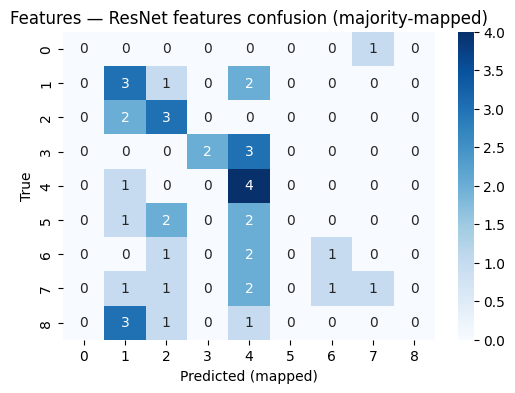

Geons ResNet-GMM accuracy (majority-mapped) = 0.773


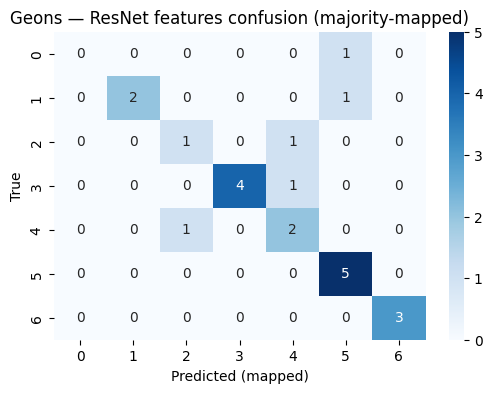

Realistic ResNet-GMM accuracy (majority-mapped) = 0.659


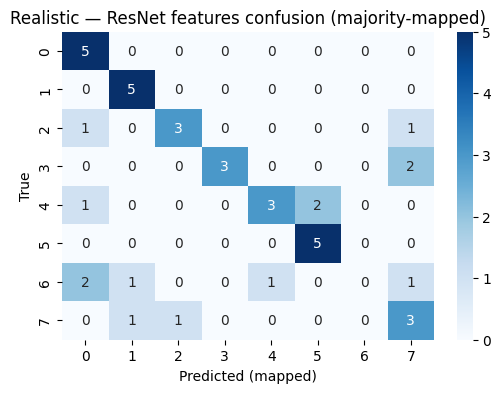

Silhouettes ResNet-GMM accuracy (majority-mapped) = 0.600


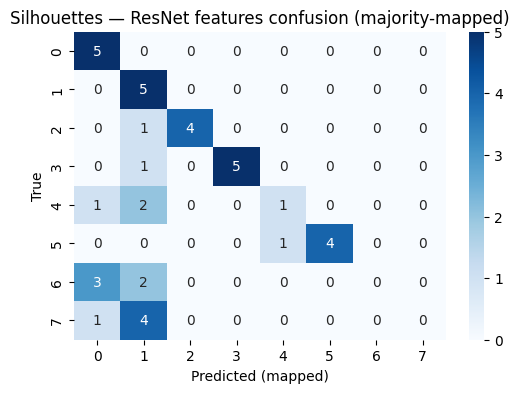

In [27]:
for name, data, y_true in zip(conditions, datasets, labels_list):
    feats = extract_features_from_flatbatch(data)              # (n, 512)
    feats_s = StandardScaler().fit_transform(feats)
    gmm = GaussianMixture(
        n_components=8,
        covariance_type='full',
        random_state=42
    ).fit(feats_s)
    y_pred = gmm.predict(feats_s)

    # map & evaluate loop
    y_pred_mapped, raw_cm = map_clusters_majority(y_true, y_pred, n_classes=8)
    acc = accuracy_score(y_true, y_pred_mapped)
    print(f"{name} ResNet-GMM accuracy (majority-mapped) = {acc:.3f}")

    plt.figure(figsize=(6,4))
    sns.heatmap(
        confusion_matrix(y_true, y_pred_mapped),
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    plt.title(f"{name} — ResNet features confusion (majority-mapped)")
    plt.xlabel("Predicted (mapped)"); plt.ylabel("True")
    plt.show()

Using ResNet features generally produces higher accuracy and clearer confusion matrices, showing that deep neural network features separate the categories more effectively than PCA features. Comparing these confusion matrices and accuracies to Part 5B, improvements are clear. In this model, we're seeing higher accuracies and clearer diagonals across the board. This is very clear in "Realistic", which saw remarkable improvement in accuracy.

#6. A) Feedforward Neural Network

Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers.

Train the network to classify images into two categories: cars and ducks, using this dataset: https://osf.io/j2sfb/files/4enzw. Use only images of cars and ducks to train the networks, 80% for training and 20% for validation; you can use data augmentation. Test the network on all images of ducks and cars (all conditions) from the dataset you used in earlier questions. For your network, choose the number of neurons you find appropriate and efficient (so you have enough time to run it). Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training.

#### Prepare the data for training

In [28]:
# Before training this dataset, let's format it properly.

_6_Train_zipfile = ZipFile("baby8_from_flickr_curated.zip")
_6_inflist = _6_Train_zipfile.infolist()

_6_Train_data = []
_6_Train_labels = []

In [29]:
identify_car0_duck1 = lambda filename: (0 if "car" in (f := filename.lower())
  else (1 if "duck" in f else -1))

for file in _6_inflist:
    if file.filename.endswith(".jpg"):

        label = identify_car0_duck1(file.filename)
        if label == -1:
            continue  # skip non-car, non-duck images

        img = Image.open(_6_Train_zipfile.open(file))
        _6_Train_data.append(np.array(img))
        _6_Train_labels.append(label)

In [30]:
print(f"Number of training datapoints: {len(_6_Train_data)}")

Number of training datapoints: 175


The smallest HxW is 176x170, so anything up to about that can be obtained with uniform resizing. Typical choices for small CNNs are in the 128-256 range and often square (e.g., 128x128, 160x160, 192x192, 224x224). We will proceed with the greyscaled images and use the 160x160 dimensions to maximize the number of variables for this.

The images happen to be RGB scaled

In [31]:
def preprocess_train_images(img_list, shape=(160, 160)):
    processed = []
    for img in img_list:
        # Ensure image is in 3 channels for PIL if it's not already
        if len(img.shape) == 2:
            pil_img = Image.fromarray(img).convert("L")
        elif img.shape[2] == 4: # RGBA
            pil_img = Image.fromarray(img).convert("RGB").convert("L")
        else: # RGB or other 3-channel
            pil_img = Image.fromarray(img).convert("L") # grayscale ("L")

        pil_img = pil_img.resize(shape) # resize
        processed.append(np.array(pil_img)) # keep as 2D array (H, W)
    return np.array(processed)

_6_Train_data_processed = preprocess_train_images(_6_Train_data)

print(f"Shape of processed training data: {_6_Train_data_processed.shape}")
print(f"length of processed training labels: {len(_6_Train_labels)}")

Shape of processed training data: (175, 160, 160)
length of processed training labels: 175


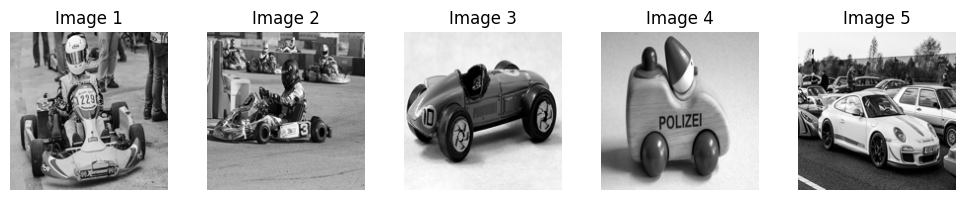

In [32]:
n_display = 5 # Number of images to display

plt.figure(figsize=(10, 2))
for i in range(n_display):
    plt.subplot(1, n_display, i + 1)
    plt.imshow(_6_Train_data_processed[i], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Frequency Map:
0: 86
1: 89



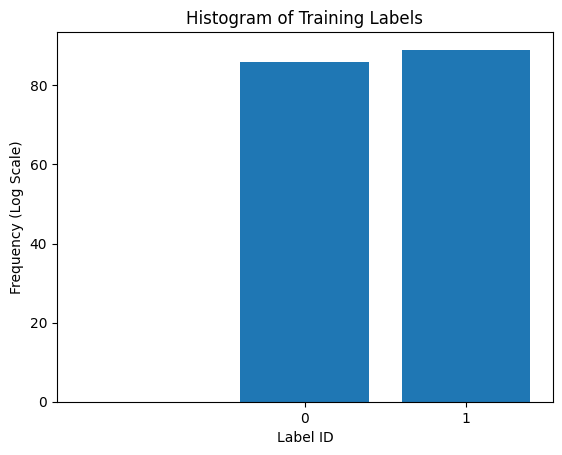

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

print("Frequency Map:")
frequency_map = Counter(_6_Train_labels)
for key, value in sorted(frequency_map.items()):
    print(f"{key}: {value}")

print()

plt.hist(_6_Train_labels, bins=range(-1, len(np.unique(_6_Train_labels)) + 1), align='left', rwidth=0.8)
plt.title('Histogram of Training Labels')
plt.xlabel('Label ID')
plt.ylabel('Frequency (Log Scale)')
plt.xticks(np.unique(_6_Train_labels)) # Ensure all unique labels are shown on x-axis
plt.show()

In [34]:
from torch.utils.data import Dataset
from torchvision import transforms

# Define Augmentations

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),  # Add this to ensure uniform size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),            # now shape (3,160,160)
])

# For validation/test, use simpler transforms without augmentation
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),  # Same size as training
    transforms.ToTensor(),
])

In [35]:
class CarDuckDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # ensure it's uint8  PIL compatible
        img = img.astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        # img is now tensor shape (3,160,160)
        img = torch.flatten(img)  # shape (76800,)

        return img, torch.tensor(label, dtype=torch.long)

In [36]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Build DataLoader

# Create the full dataset
full_dataset = CarDuckDataset(
    _6_Train_data,
    _6_Train_labels,
    transform=train_transforms
)

# Split into train and validation (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply different transforms
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 140
Validation samples: 35


#### Train the model

In [37]:
import time

In [38]:
import torch
import torch.nn as nn

class CarDuckModel(nn.Module):
    def __init__(self):
        super(CarDuckModel, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # (batch, 3, 160, 160) -> (batch, 76800)
            nn.Linear(3 * 160 * 160, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)  # 2 classes: car and duck
        )

    def forward(self, x):
        return self.model(x)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Init the model
model = CarDuckModel()

# Set the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [40]:
import matplotlib.pyplot as plt

time_start = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
patience = 3  # Stop if no improvement for 3 epochs
best_val_loss = float('inf')
patience_counter = 0

# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device).float()
        labels = labels.to(device)

        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device).float()
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    # Store metrics
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(
    f"Epoch [{epoch+1}/{num_epochs}]  "
    f"Train Loss: {avg_train_loss:.3f}  "
    f"Train Acc: {train_acc:.4f}  "
    f"Val Loss: {avg_val_loss:.3f}  "
    f"Val Acc: {val_acc:.4f}"
    )

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"   New best model saved!")
    else:
        patience_counter += 1
        print(f"   No improvement ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

time_end = time.time()
time_took = time_end - time_start
print(f"\nTraining completed in {time_took:.2f} seconds")

Epoch [1/20]  Train Loss: 6.810  Train Acc: 0.5000  Val Loss: 2.591  Val Acc: 0.5429
   New best model saved!
Epoch [2/20]  Train Loss: 6.436  Train Acc: 0.4786  Val Loss: 0.865  Val Acc: 0.5143
   New best model saved!
Epoch [3/20]  Train Loss: 6.550  Train Acc: 0.4929  Val Loss: 4.069  Val Acc: 0.5429
   No improvement (1/3)
Epoch [4/20]  Train Loss: 5.190  Train Acc: 0.5071  Val Loss: 0.934  Val Acc: 0.8286
   No improvement (2/3)
Epoch [5/20]  Train Loss: 3.780  Train Acc: 0.4714  Val Loss: 1.815  Val Acc: 0.5429
   No improvement (3/3)
Early stopping triggered after 5 epochs

Training completed in 5.27 seconds


#6. B) Report The Training Time

In [41]:
print(f"Training time: {time_took:.2f} seconds")

Training time: 5.27 seconds


#6. C) Training and Validation Loss/Accuracy

Plot training and validation loss and accuracy as a function of training epochs.

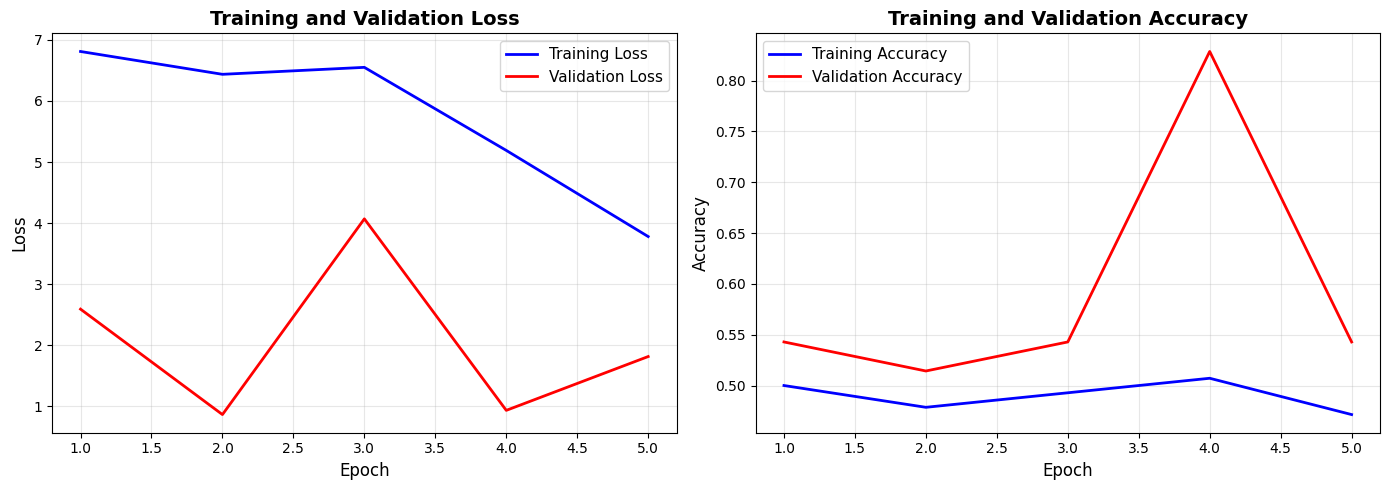


Best model loaded for evaluation


In [42]:
# Plot training and validation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot Accuracy
ax2.plot(epochs_range, train_accs, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print("\nBest model loaded for evaluation")

#6. D) Count Parameters

How many parameters does the network have? How many of those parameters are bias parameters?

In [43]:
# Count parameters
total_params = 0
bias_params = 0

print("Layer-wise parameter breakdown:")
print("-" * 60)

for name, param in model.named_parameters():
    num_params = param.numel()
    total_params += num_params

    if 'bias' in name:
        bias_params += num_params
        print(f"{name:30s} {num_params:>10,} (bias)")
    else:
        print(f"{name:30s} {num_params:>10,}")

print("-" * 60)
print(f"Total parameters:              {total_params:>10,}")
print(f"Bias parameters:               {bias_params:>10,}")
print(f"Weight parameters:             {total_params - bias_params:>10,}")
print(f"Bias percentage:               {100 * bias_params / total_params:>9.2f}%")

Layer-wise parameter breakdown:
------------------------------------------------------------
model.1.weight                 19,660,800
model.1.bias                          256 (bias)
model.4.weight                     32,768
model.4.bias                          128 (bias)
model.7.weight                        256
model.7.bias                            2 (bias)
------------------------------------------------------------
Total parameters:              19,694,210
Bias parameters:                      386
Weight parameters:             19,693,824
Bias percentage:                    0.00%


### Test the model

In [44]:
test_folders = blurred_folder + features_folder + geons_folder + realistic_folder + silhouettes_folder
test_labels = blurred_labels + features_labels + geons_labels + realistic_labels + silhouettes_labels

In [45]:
labels = {"airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"}

# Create a mapping from label names to numbers
label_to_num = {label: idx for idx, label in enumerate(sorted(labels))}

In [46]:
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

test_dataset = CarDuckDataset(test_folders, test_labels, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [47]:
# Test the model

model.eval()
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device).float()
        labels = labels.to(device)

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total

print(f"\nTest Set Results:")
print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")
print(f"Test Error Rate: {1 - test_acc:.4f}")


Test Set Results:
Test Accuracy: 0.1337 (25/187)
Test Error Rate: 0.8663
